# On-Time Delivery Prediction

### 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib
import zipfile

### 2. Load Data

In [2]:
# Load Data
def load_data(zip_path, file_name):
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extract(file_name)
    data = pd.read_csv(file_name)
    print("Data loaded successfully.")
    return data

# Replace with the actual file name inside the ZIP file
zip_path = 'On-Time Delivery.zip'
file_name = 'Train new.csv'  # Adjust based on actual file
data = load_data(zip_path, file_name)

# Inspect the dataset
print("Dataset Overview:")
print(data.info())
print("\nFirst 5 Rows:")
print(data.head())
print("\nMissing Values Summary:")
print(data.isnull().sum())

Data loaded successfully.
Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB
None

First 5 Rows:
   ID Warehouse_block Mode_of_Shipment  Customer_care_calls  Customer_rating  \
0   1      

### 3. Preprocess Data

In [3]:
def preprocess_data(df):
    # Create a copy to avoid modifying the original dataframe
    df = df.copy()
    
    # Define categorical and numerical columns
    categorical_cols = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']
    numerical_cols = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 
                     'Prior_purchases', 'Discount_offered', 'Weight_in_gms']
    
    # Handle missing values separately for numerical and categorical columns
    # For numerical columns, fill with median
    for col in numerical_cols:
        if df[col].isnull().any():
            df[col].fillna(df[col].median(), inplace=True)
    
    # For categorical columns, fill with mode
    for col in categorical_cols:
        if df[col].isnull().any():
            df[col].fillna(df[col].mode()[0], inplace=True)
    
    # Preprocessing pipeline with handle_unknown='ignore'
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
        ])
    
    # Apply preprocessing
    X = df.drop(columns=['Reached.on.Time_Y.N', 'ID'])  # Drop ID as it's not relevant
    y = df['Reached.on.Time_Y.N']  # Target variable
    
    X_preprocessed = preprocessor.fit_transform(X)
    
    return X_preprocessed, y, preprocessor

### 4. Handle Class Imbalance with SMOTE

In [4]:
# Run the preprocessing to get X and y
X, y, preprocessor = preprocess_data(data)

# Now split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Then apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nTraining Data Shape:", X_train_resampled.shape)
print("Testing Data Shape:", X_test.shape)


Training Data Shape: (10500, 15)
Testing Data Shape: (2200, 15)


### 5. Train Model

In [5]:
# Model Training with Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Best model
best_model = grid_search.best_estimator_
print("\nBest Model Parameters:", grid_search.best_params_)


Best Model Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


### 6. Save the model

In [6]:
joblib.dump(best_model, 'on_time_delivery_model.pkl')
print("Model training complete. Model saved as 'on_time_delivery_model.pkl'.")

Model training complete. Model saved as 'on_time_delivery_model.pkl'.


### 7. Model Evaluation

Accuracy: 0.66
Precision: 0.79
Recall: 0.59
F1-Score: 0.68
ROC-AUC: 0.74


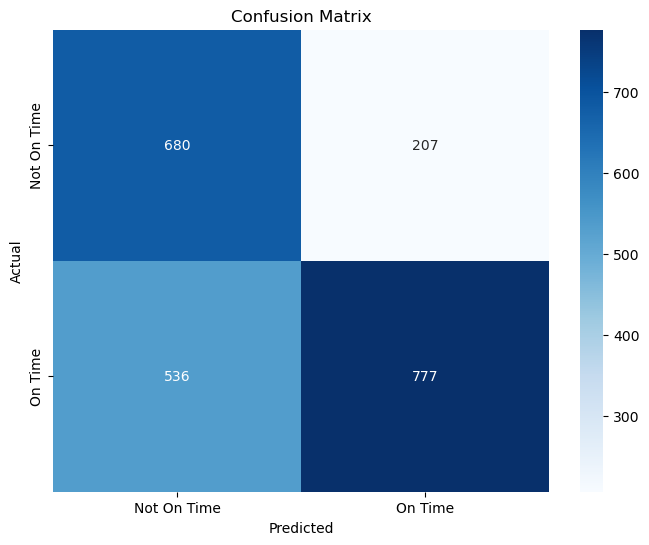


Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.77      0.65       887
           1       0.79      0.59      0.68      1313

    accuracy                           0.66      2200
   macro avg       0.67      0.68      0.66      2200
weighted avg       0.70      0.66      0.66      2200



In [7]:
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:, 1]  # Probability of the positive class

    # Classification Metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, probabilities)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"ROC-AUC: {roc_auc:.2f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not On Time', 'On Time'], yticklabels=['Not On Time', 'On Time'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, predictions))

evaluate_model(best_model, X_test, y_test)


### 8. Make a Prediction

In [8]:
def predict_on_time_delivery(model, new_data, preprocessor):
    """
    Predict whether an order will be delivered on time.
    """
    # Make a copy to avoid modifying original data
    new_data = new_data.copy()
    
    # Define the expected column order
    expected_columns = [
        'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product',
        'Prior_purchases', 'Discount_offered', 'Weight_in_gms',
        'Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender'
    ]
    
    # Convert categorical variables to lowercase
    categorical_cols = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']
    for col in categorical_cols:
        new_data[col] = new_data[col].str.lower()
    
    # Reorder columns to match training data
    new_data = new_data[expected_columns]
    
    try:
        # Preprocess new data
        new_data_preprocessed = preprocessor.transform(new_data)
        
        # Make predictions
        predictions = model.predict(new_data_preprocessed)
        probabilities = model.predict_proba(new_data_preprocessed)
        
        return predictions, probabilities
    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        return None, None

# Example new data with raw input
new_order = pd.DataFrame({
    'Customer_care_calls': [3],
    'Customer_rating': [4],
    'Cost_of_the_Product': [200],
    'Prior_purchases': [2],
    'Gender': ['Male'],
    'Discount_offered': [10],
    'Weight_in_gms': [1200],
    'Warehouse_block': ['A'],
    'Mode_of_Shipment': ['Flight'],
    'Product_importance': ['medium']  # Changed to lowercase
})

# Make prediction
predictions, probabilities = predict_on_time_delivery(best_model, new_order, preprocessor)

if predictions is not None:
    status = "On Time" if predictions[0] == 1 else "Not On Time"
    confidence = max(probabilities[0]) * 100
    print(f"Predicted Delivery Status: {status}")
    print(f"Confidence: {confidence:.2f}%")

Predicted Delivery Status: On Time
Confidence: 84.00%


C:\Users\milto\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
